# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## AT LAST - it's time for Fine Tuning!

After all this data preparation, and old school machine learning, we've finally arrived at the moment you've been waiting for. Fine-tuning a model.

In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [ ]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from items import Item
from testing import Tester

In [ ]:
openai = OpenAI()

In [6]:
%matplotlib inline

In [7]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [8]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

# Step 1

Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [9]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [10]:
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\n1970's Captain's Lamp With Tripod Stand in Brass Finish Floor Lamp Marine Collection\nA magnificent new large designer Hand Made nautical signal light with timber tripod. Direct to you from the importer at a fraction of the retail price. A beautiful Designer piece for the home or office. Much larger than the other models I sell, sure to make a bold statement in any room. The lamp head is adjustable and easily pops open to change the globe. It takes regular household screw in light globes. The legs adjust to the desired height so that it can be used as both a floor lamp or table lamp. Dimensions 98cm min Height, 190cm max Height. Lamp head is 36cm diameter, x 31cm deep. Takes regular E27 screw in light globes. Vintage"},
 {'role': 'assistant', 'content': 'Price is $152.00'}]

In [11]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [12]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\n1970's Captain's Lamp With Tripod Stand in Brass Finish Floor Lamp Marine Collection\nA magnificent new large designer Hand Made nautical signal light with timber tripod. Direct to you from the importer at a fraction of the retail price. A beautiful Designer piece for the home or office. Much larger than the other models I sell, sure to make a bold statement in any room. The lamp head is adjustable and easily pops open to change the globe. It takes regular household screw in light globes. The legs adjust to the desired height so that it can be used as both a floor lamp or table lamp. Dimensions 98cm min Height, 190cm max Height. Lamp head is 36cm diameter, x 31cm deep. Takes regular E27 screw in light globes. Vintage"}, {"role": "assistant", "content": "Price is $152.00"}]}
{"messages": [{"role": "system", "cont

In [13]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [14]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [15]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [16]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [17]:
train_file

FileObject(id='file-NhvuMzN6y3yfXYK9EqRrFF', bytes=190969, created_at=1742305706, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [18]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [19]:
validation_file

FileObject(id='file-HKeYkwrxSaWGiUg7mwuZep', bytes=46823, created_at=1742305717, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

# Step 2

I love Weights and Biases - a beautiful, free platform for monitoring training runs.  
Weights and Biases is integrated with OpenAI for fine-tuning.

First set up your weights & biases free account at:

https://wandb.ai

From the Avatar >> Settings menu, near the bottom, you can create an API key.

Then visit the OpenAI dashboard at:

https://platform.openai.com/account/organization

In the integrations section, you can add your Weights & Biases key.

## And now time to Fine-tune!

In [20]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [21]:
train_file.id

'file-NhvuMzN6y3yfXYK9EqRrFF'

In [22]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-qw9XVr8NTzVJzRgny0cJD323', created_at=1742306667, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-I5vDNMqzg5yfexckLUwxzfFn', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-NhvuMzN6y3yfXYK9EqRrFF', validation_file='file-HKeYkwrxSaWGiUg7mwuZep', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-qw9XVr8NTzVJzRgny0cJD323'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [23]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-qw9XVr8NTzVJzRgny0cJD323', created_at=1742306667, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-I5vDNMqzg5yfexckLUwxzfFn', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-NhvuMzN6y3yfXYK9EqRrFF', validation_file='file-HKeYkwrxSaWGiUg7mwuZep', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-qw9XVr8NTzVJzRgny0cJD323'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix=

In [24]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [25]:
job_id

'ftjob-qw9XVr8NTzVJzRgny0cJD323'

In [30]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-qw9XVr8NTzVJzRgny0cJD323', created_at=1742306667, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-I5vDNMqzg5yfexckLUwxzfFn', result_files=[], seed=42, status='running', trained_tokens=None, training_file='file-NhvuMzN6y3yfXYK9EqRrFF', validation_file='file-HKeYkwrxSaWGiUg7mwuZep', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-qw9XVr8NTzVJzRgny0cJD323'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [34]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-zaRDF25EwyV3s7nzRgMYoLjs', created_at=1742308523, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-VoVJp7zjCaxLj8PhgnJksaRw', created_at=1742308519, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-DX5X2DGOhizDYSQzNCuwMHTE', created_at=1742308486, level='info', message='Step 200/200: training loss=1.36, validation loss=1.39, full validation loss=1.09', object='fine_tuning.job.event', data={'step': 200, 'train_loss': 1.3593034744262695, 'valid_loss': 1.390242099761963, 'total_steps': 200, 'full_valid_loss': 1.0859148931503295, 'train_mean_token_accuracy': 0.75, 'valid_mean_token_accuracy': 0.75, 'full_valid_mean_token_accuracy': 0.7825}, type='metrics'),
 FineTuningJobEvent(id='ftevent-NqaY4EmLfTwKLnpXTOpdS06u', created_at=1742308475, level='info', message='Step 

# Step 3

Test our fine tuned model

In [35]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [36]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:BCSKExSH'

In [37]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [38]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nTLAPS Compatible With Toyota Tacoma Non-Factory LED LED DRL Black Housing Full LED Sequential Quad Projector Headlights With Amber Reflector\nApplication Compatible With Toyota Tacoma Models With Non-Factory LED DRL ( Daytime Running Lights ) Headlights Only ( Attention Note Will Not Fit Models With Factory LED DRL ( Daytime Running Lights ) Headlights, Hyper Blinking May Occur If Used With Other Branded Aftermarket LED Lighting ) Full LED Sequential Projector Headlights ( Attention These LED Projector Headlights Will ONLY Replace Factory OEM Halogen Style Headlights, Not Compatible With Factory Upgraded Projectors Or LED Headlights, Hyper Blinking May Occur If Used With Other Branded Aftermarket LED Lighting. For More Information Please Contact Us ) Quad-LED Projector Design With Amber Sequential'},
 {'role': 'assistan

In [39]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [40]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [41]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [42]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

389.0
127.99


In [43]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

TLAPS Compatible With Toyota Tacoma Non-Factory LED LED DRL Black Housing Full LED Sequential Quad Projector Headlights With Amber Reflector
Application Compatible With Toyota Tacoma Models With Non-Factory LED DRL ( Daytime Running Lights ) Headlights Only ( Attention Note Will Not Fit Models With Factory LED DRL ( Daytime Running Lights ) Headlights, Hyper Blinking May Occur If Used With Other Branded Aftermarket LED Lighting ) Full LED Sequential Projector Headlights ( Attention These LED Projector Headlights Will ONLY Replace Factory OEM Halogen Style Headlights, Not Compatible With Factory Upgraded Projectors Or LED Headlights, Hyper Blinking May Occur If Used With Other Branded Aftermarket LED Lighting. For More Information Please Contact Us ) Quad-LED Projector Design With Amber Sequential

Price is $


1: Guess: $127.99 Truth: $389.00 Error: $261.01 SLE: 1.22 Item: TLAPS 7422444293245 Compatible With 2016...
2: Guess: $47.22 Truth: $11.95 Error: $35.27 SLE: 1.73 Item: Witonics Capacitor Replacement Kit for L...
3: Guess: $127.22 Truth: $57.99 Error: $69.23 SLE: 0.60 Item: EPSIRMP E5T62172 Mass Air Flow Meter Sen...
4: Guess: $49.77 Truth: $32.99 Error: $16.78 SLE: 0.16 Item: 2 Pc 4 in 1 Double Box Ratcheting Wrench...
5: Guess: $161.18 Truth: $136.94 Error: $24.24 SLE: 0.03 Item: Can-Am 2013-2018 Outlander 650 Outlander...
6: Guess: $147.00 Truth: $116.10 Error: $30.90 SLE: 0.05 Item: OREI KVM 4K HDMI Over Ethernet Extender ...
7: Guess: $262.47 Truth: $249.97 Error: $12.50 SLE: 0.00 Item: MAXLINER Custom Fit Floor Mats and Cargo...
8: Guess: $109.95 Truth: $151.89 Error: $41.94 SLE: 0.10 Item: Alpinestars (474512-20-XS/S White X-Smal...
9: Guess: $128.66 Truth: $110.99 Error: $17.67 SLE: 0.02 Item: SCITOO automotive replacement engine rad...
10: Guess: $322.22 Truth: $218.78 Error: 

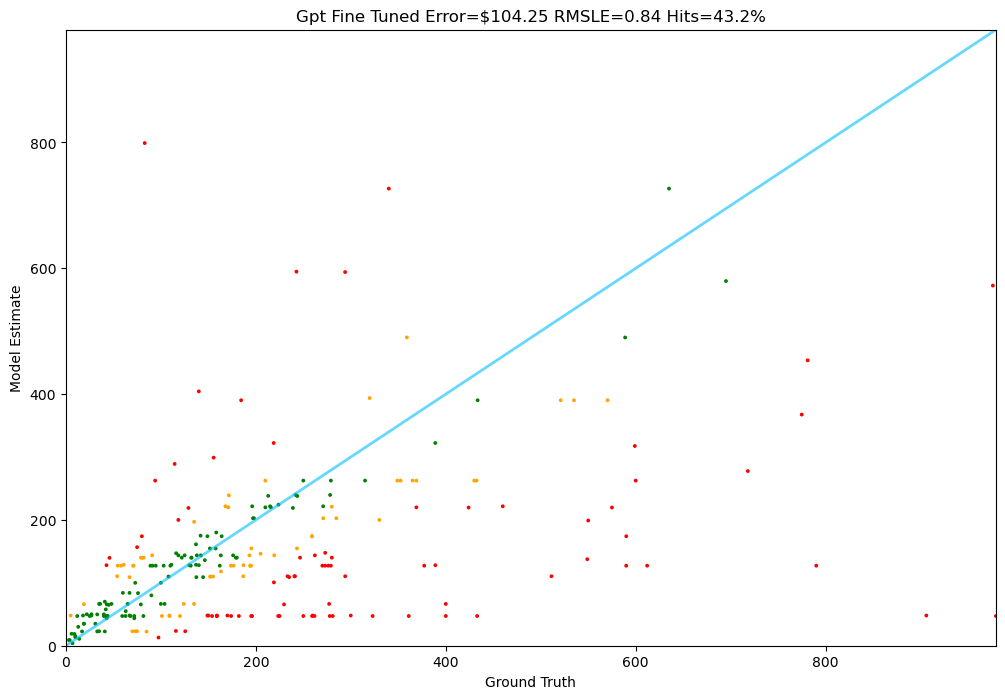

In [44]:
Tester.test(gpt_fine_tuned, test)